In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#회귀분석
from statsmodels.formula.api import ols

#qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant

#선형 모델 formula(y~X1 + X2+ ...)
import statsmodels.formula.api as smf

#평가함수
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

#다중공산성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

#선형회귀모형
from sklearn.linear_model import LinearRegression

#변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

#scale 변환 -> 표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

#나무 구조 생성 및 저장
from sklearn.tree import export_graphviz

#나무 구조 시각화(.dot 확장자 파일 불러오기)
import graphviz

#데이터 분할 : train, test
from sklearn.model_selection import train_test_split

#예측/회귀 decision tree
from sklearn.tree import DecisionTreeRegressor

#예측/회귀 Random Forest
from sklearn.ensemble import RandomForestRegressor as RFR

#최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

In [2]:
matplotlib.rc('font', family = 'NanumGothic')

## 1. 회귀분석_예측

In [59]:
df_raw = pd.read_csv('/home/piai/Downloads/체질검사.csv', engine = 'python')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


### STEP2: 변수 간의 경향성 파악 - 그래프 분석


### BMI 파생변수 생성

In [60]:
df_raw['BMI'] = (df_raw['WEIGHT']*0.45) /np.square((df_raw['HEIGHT']*2.54)/100)

In [61]:
df_raw['BMI'].describe()

count    252.000000
mean      25.736762
std        9.482758
min       17.874982
25%       22.853241
50%       24.895566
75%       27.118085
max      164.306562
Name: BMI, dtype: float64

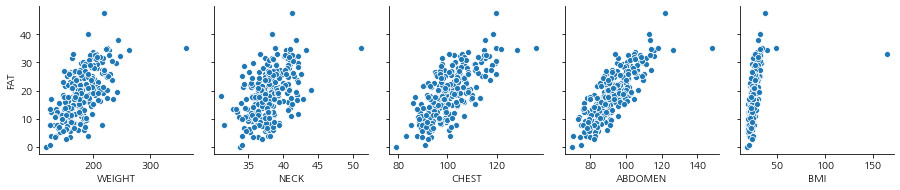

In [62]:
sns.pairplot(df_raw, y_vars = 'FAT', x_vars = ['WEIGHT','NECK','CHEST','ABDOMEN','BMI'])

### BMI 이상치 제거

In [63]:
df_raw.loc[df_raw['BMI'] == df_raw['BMI'].max()]

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
78,32.9,44,205.0,29.5,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4,164.306562


In [64]:
df_raw.drop(index= 78, inplace = True)

In [65]:
df_raw['BMI'].max()
df_raw = df_raw.reset_index()

### 변수 간의 경향성 파악 - 그래프 분석

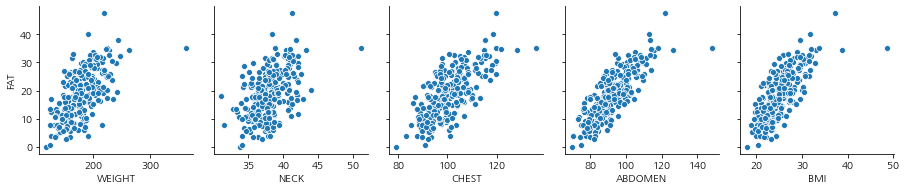

In [10]:
#산점도 행렬: 목표변수와 설명변수 지정, kind ='scatter', 'reg'
sns.pairplot(df_raw, y_vars = 'FAT', x_vars = ['WEIGHT','NECK','CHEST','ABDOMEN','BMI'])

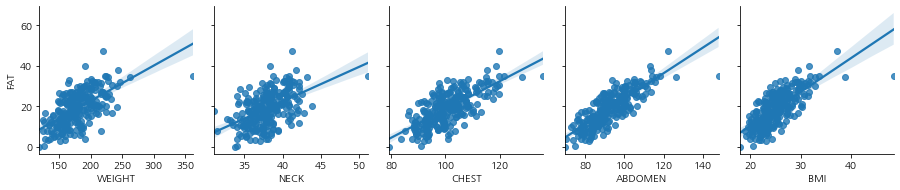

In [11]:
#회귀 적합선 추가 : kind = 'reg'
sns.pairplot(df_raw, y_vars = 'FAT', x_vars = ['WEIGHT','NECK','CHEST','ABDOMEN','BMI'], kind = 'reg')

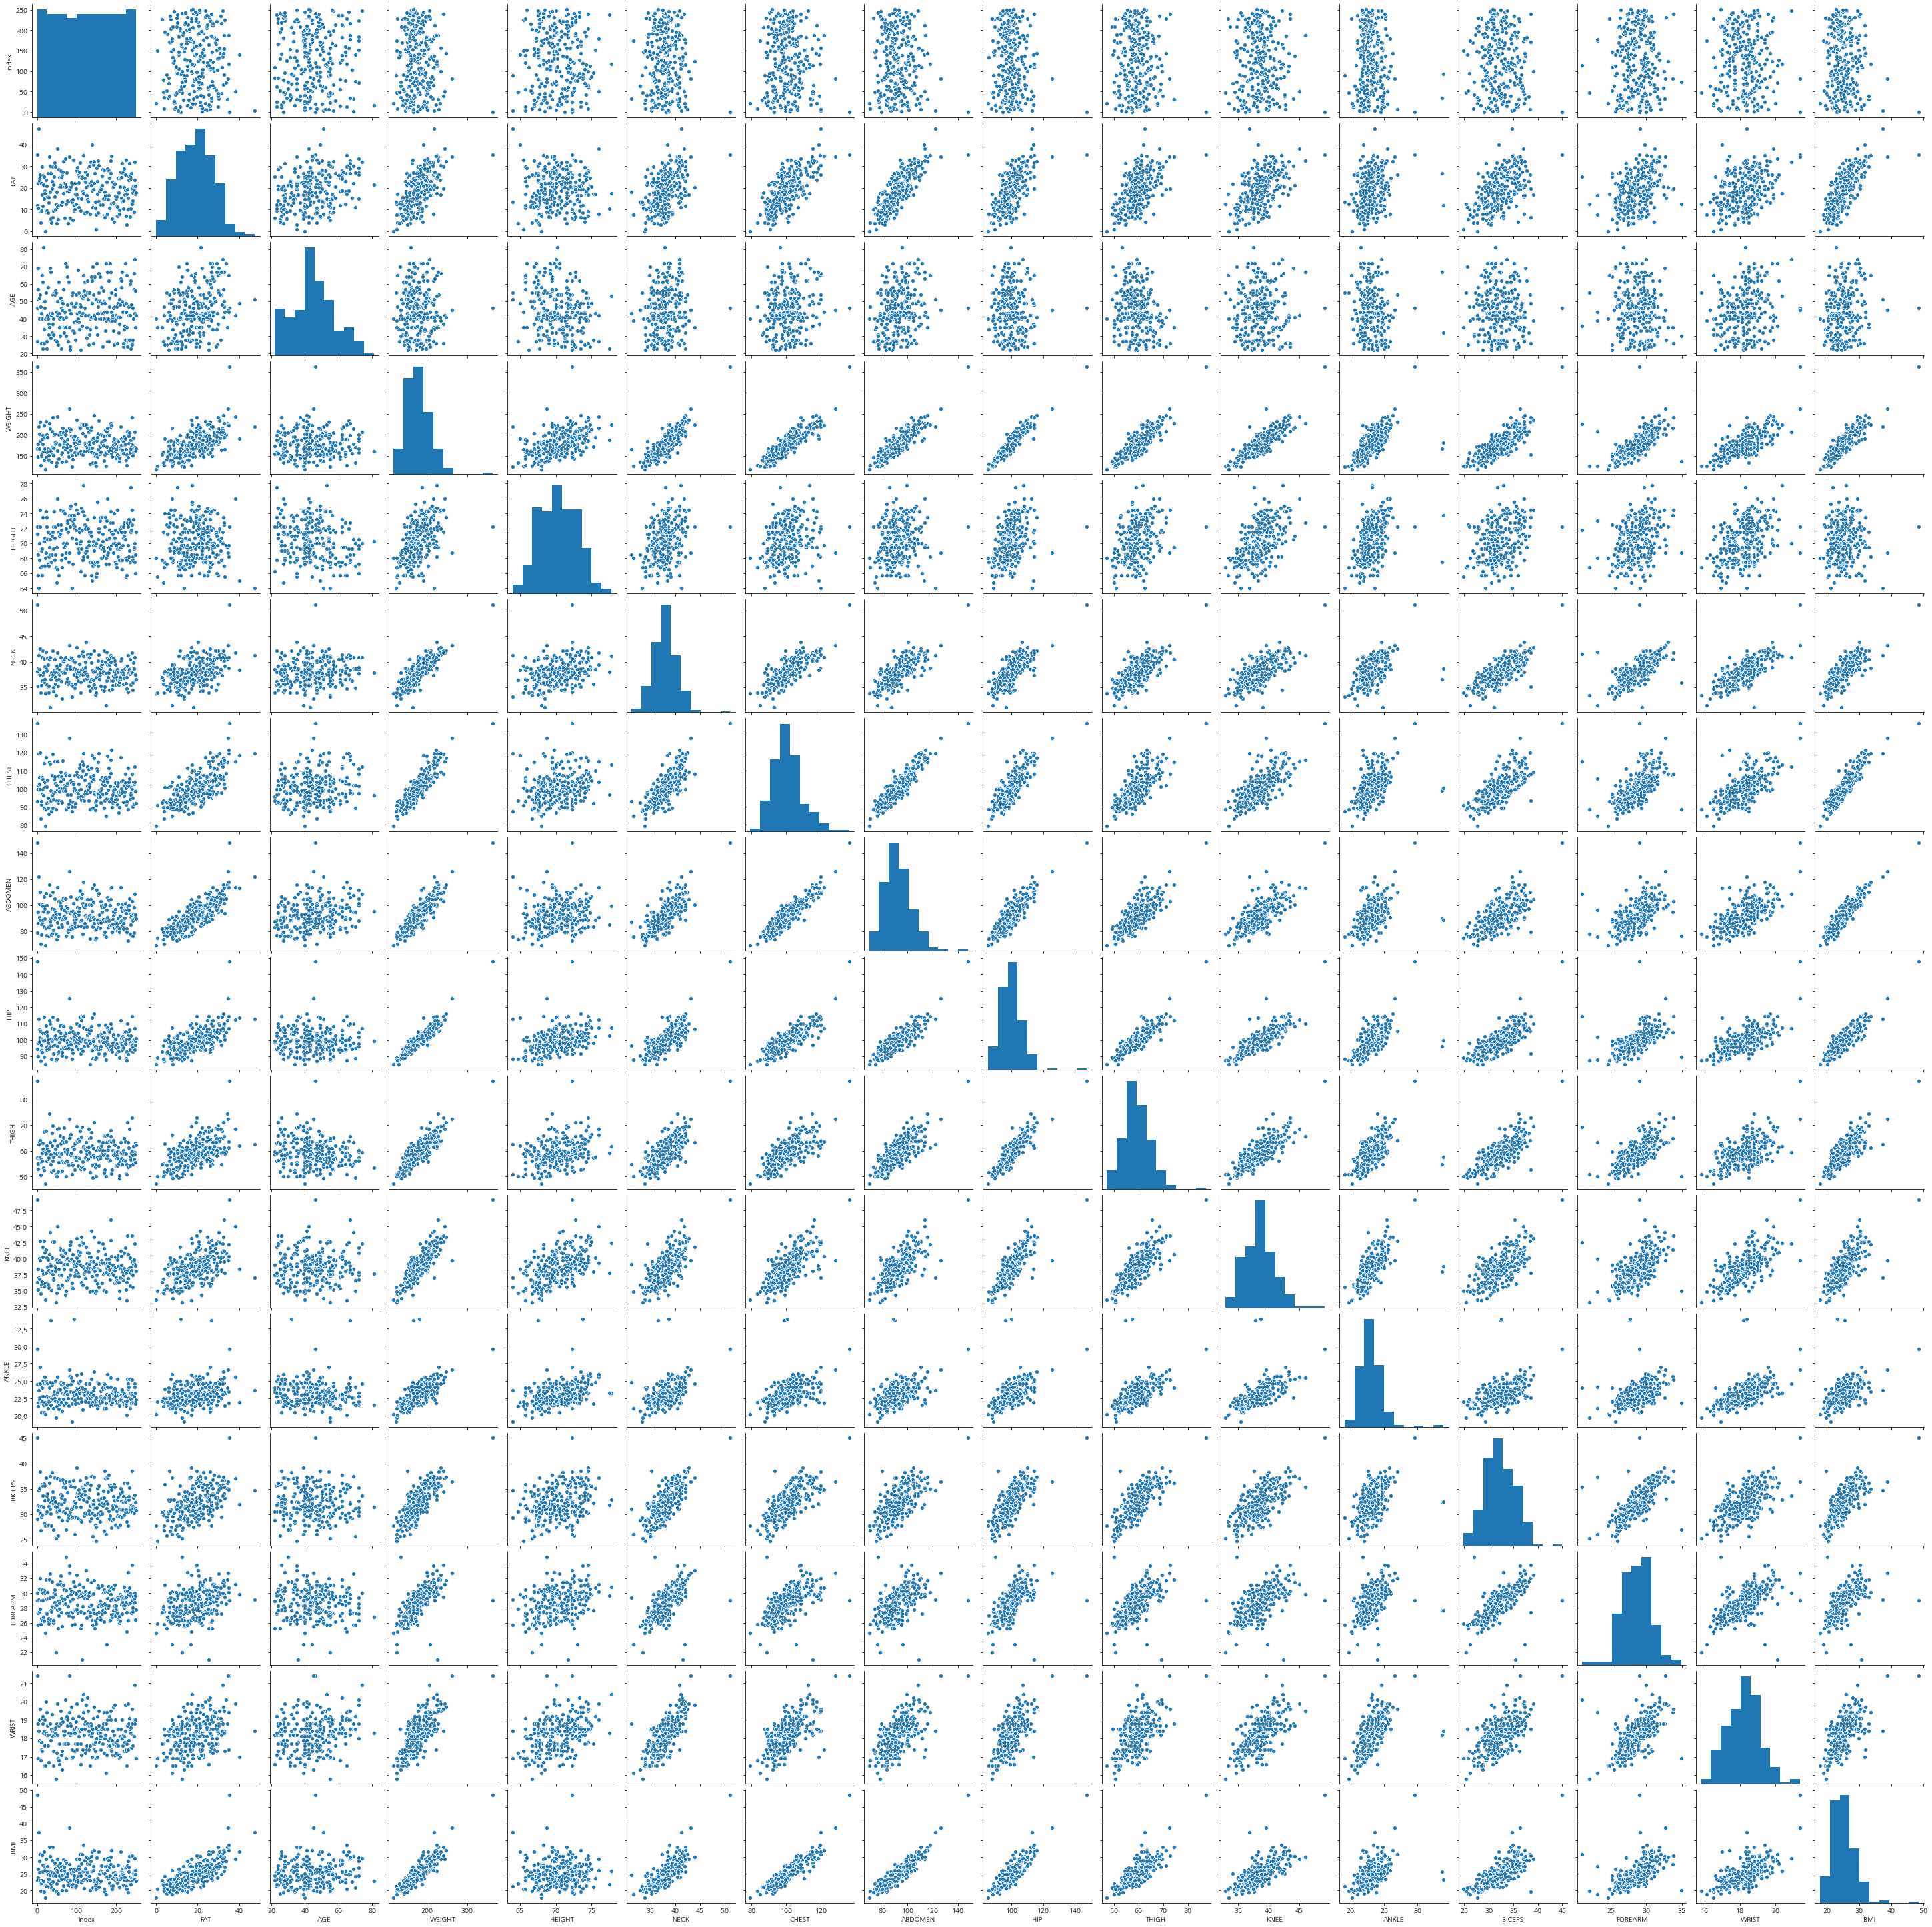

In [12]:
#산점도 행렬: 전체 숫자형 변수
sns.pairplot(df_raw)

### 변수 간의 경향성 파악 - 상관관계 분석

In [66]:
#상관관계 분석
df_raw.corr().round(3)

,index,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
index,1.000,-0.024,0.021,-0.083,0.015,-0.057,-0.062,-0.068,-0.101,-0.056,-0.012,-0.096,-0.071,-0.021,-0.030,-0.099
FAT,-0.024,1.000,0.294,0.611,-0.023,0.497,0.703,0.813,0.620,0.554,0.503,0.265,0.493,0.363,0.355,0.725
AGE,0.021,0.294,1.000,-0.013,-0.245,0.113,0.177,0.231,-0.050,-0.201,0.018,-0.105,-0.041,-0.085,0.214,0.115
WEIGHT,-0.083,0.611,-0.013,1.000,0.489,0.835,0.894,0.888,0.944,0.870,0.853,0.614,0.800,0.631,0.735,0.888
HEIGHT,0.015,-0.023,-0.245,0.489,1.000,0.321,0.228,0.192,0.378,0.344,0.505,0.394,0.319,0.322,0.397,0.039
NECK,-0.057,0.497,0.113,0.835,0.321,1.000,0.787,0.759,0.748,0.708,0.680,0.479,0.733,0.624,0.744,0.785
CHEST,-0.062,0.703,0.177,0.894,0.228,0.787,1.000,0.916,0.833,0.732,0.720,0.483,0.728,0.581,0.664,0.910
ABDOMEN,-0.068,0.813,0.231,0.888,0.192,0.759,0.916,1.000,0.875,0.766,0.736,0.453,0.685,0.504,0.626,0.922
HIP,-0.101,0.620,-0.050,0.944,0.378,0.748,0.833,0.875,1.000,0.894,0.821,0.561,0.743,0.550,0.645,0.885
THIGH,-0.056,0.554,-0.201,0.870,0.344,0.708,0.732,0.766,0.894,1.000,0.797,0.542,0.765,0.572,0.572,0.814


* FAT와 WEIGHT, CHEST, ABDOMEN, HIP, BMI 간의 높은 선형관계 확인

### STEP3: 회귀 모델 생성- 설명변수 전체

In [67]:
# 선형회귀분석 formula 이용, 상수항(intercept)자동 추가.
reg_model = smf.ols(formula = 'FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE +BICEPS + FOREARM + WRIST + BMI', data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     51.59
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.29e-63
Time:                        22:47:51   Log-Likelihood:                -712.18
No. Observations:                 251   AIC:                             1454.
Df Residuals:                     236   BIC:                             1507.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -148.1387     52.793     -2.806      0.0

* 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의하다
* AGE, WEIGHT, HEIGHT, ABDOMEN, FOREARM, WRIST, BMI의 p값이 유의수준 0.05보다 작으므로 유의하다

### 회귀 모델 생성: 설명변수 간의 다중공선성 확인


In [68]:
#설명변수 데이터 생성
df_raw_x = df_raw.drop('FAT', axis = 1)

#statsmodel 의 상수항 추가 함수 적용
df_raw_x_const = add_constant(df_raw_x)

#DataFrame 으로 저장
df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values('VIF', inplace = True)
df_vif.round(3)

,variable,VIF
1,index,1.053
11,ANKLE,1.956
13,FOREARM,2.259
2,AGE,2.270
14,WRIST,3.394
12,BICEPS,3.674
5,NECK,4.451
10,KNEE,4.916
9,THIGH,7.911
6,CHEST,10.775


* WEIGHT와 BMI 의 VIF가 크기 땜누에 이를 모델에서 제외한다

### VIF 체크 후 , WEIGHT 와 BMI 제거

In [69]:
reg_model = smf.ols(formula = 'FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE +BICEPS + FOREARM + WRIST', data = df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     57.61
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           2.07e-63
Time:                        22:47:54   Log-Likelihood:                -717.09
No. Observations:                 251   AIC:                             1460.
Df Residuals:                     238   BIC:                             1506.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3921      8.737      1.189      0.2

* 분산분석 결과 p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의하다
* AGE, NECK, ABDOMEN, FOREARM, HIP, FOREARM, WRIST의 p값이 유의수준 0.05보다 작으므로 유의하다

### 회귀 모델 생성: 설명변수 간의 다중공선성 재확인

In [70]:
#다중공선성 높은 변수 제거 후 공선성 재확인
df_raw_x = df_raw.drop(['FAT','WEIGHT','BMI'], axis = 1)

#statsmodels의 상수항 추가 함수 적
df_raw_x_const = add_constant(df_raw_x)

#DataFrame 으로 저장
df_vif = pd.DataFrame()
df_vif['variable'] = df_raw_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

#VIF 정렬
df_vif.sort_values('VIF', inplace = True)
df_vif.round(3)

,variable,VIF
1,index,1.044
3,HEIGHT,1.757
10,ANKLE,1.862
2,AGE,2.182
12,FOREARM,2.195
13,WRIST,3.311
11,BICEPS,3.513
4,NECK,3.952
9,KNEE,4.768
8,THIGH,7.758


* 처리 후 다중공선성의 문제가 거의 해결된 것을 볼 수 있다

### 후진제거법을 이용한 변수 선택


In [71]:
#RFE 함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거
#목표 변수 분리
df_raw_y = df_raw['FAT']

#sklearn의 선형회귀 모델
model = LinearRegression()

#전체 변수 중 5개의 변수가 남을 때까지 변수 선택
rfe = RFE(estimator = model, n_features_to_select = 5).fit(df_raw_x, df_raw_y)

#선택된 변수
selected_cols = df_raw_x.columns[rfe.support_]

#제거된 변수
removed_cols = df_raw_x.columns[~rfe.support_]


print(f'Selected Vairables : {selected_cols}')
print(f'Removed Variables : {removed_cols}')

Selected Vairables : Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['index', 'AGE', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


In [72]:
#선택된 5개 변수를 넣고 모델 생성
rfe_reg_model = smf.ols(formula = 'FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST', data = df_raw)

#모델적용 
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.45e-67
Time:                        22:48:05   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5851      6.224      0.415      0.6

### 결론 도출

최종 모델의 회귀식  
y = 2.5851 -0.5720NECK + 0.9771ABDOMEN -0.3537HIP + 0.3537FOREARM -1.5647WRIST

* 손목 두께(WRIST)가 얇을수록 체질 비만도가 높음
* 복부 둘레(ABDOMEN)가 커질수록 체질 비만도가 높음
* NECK이 작을수록 체질 비만도가 높음
* HIP이 작을수록 체질 비만도가 높음
* FOREARM이 커질수록 체질 비만도가 높음

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


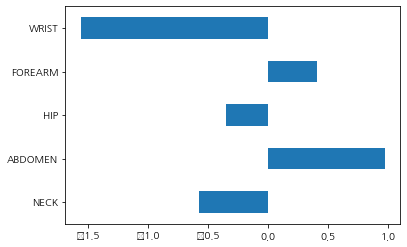

In [20]:
#설명변수 중요도(표준화 적용 이전) -> 표준화 회귀계수 산출해야 함
df_reg_coef = pd.DataFrame({'Coef': rfe_reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y = 'Coef', legend = False)

* 가장 큰 음의 영향을 주는 것은 WRIST. 가장 큰 양의 영향은 ABDOMEN

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.45e-67
Time:                        22:34:09   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.0960      0.276     69.106      0.0

/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


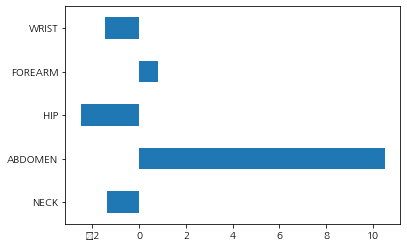

In [21]:
#표준화 회귀계수를 이용한 변수 중요도 확인

#설명변수 표준화 적용 -> 표준화 회귀계수 산출 목적
scaler = StandardScaler()

#scale 변환대상 변수 : 일반적으로 설명변수
cols = df_raw_x.columns

#Scale 변환
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

#목표변수 추가
df_scaled['FAT'] = df_raw['FAT']
reg_model_scaled = smf.ols(formula = 'FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST', data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

#설명변수 중요도(표준화 적용 이전)-> 표준화 회귀계수 산출해야 함
df_reg_coef = pd.DataFrame({'Coef': reg_result_scaled.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y = 'Coef', legend = False)

* 복부 둘레(ABDOMEN)가 가장 주용하고 손목두께(WRIST)의 중요도는 줄어든 반면 엉덩이(HIP)변수의 중요도는 증가했다.
* 단, 모델의 통계량에는 변화가 없다

## 2. 의사결정나무

### STEP1 데이터 구성

In [22]:
df_raw = pd.read_csv('/home/piai/Downloads/Concrete.csv', engine = 'python')
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [23]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['CONCRETE_COMPRESSIVE_STRENGTH']
df_raw_x = df_raw.drop('CONCRETE_COMPRESSIVE_STRENGTH', axis = 1 , inplace = False)

### train:val:test 를 4:3:3의 비율로 분할

In [24]:
#train_test_split (X : 설명변수 데이터, Y : 목표변수 데이터, test_size = test 데이터 비율, random_state : random seed)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,test_size = 0.3, random_state = 1234)
df_train_x, df_val_x, df_train_y , df_val_y = train_test_split(df_train_x, df_train_y, test_size = 3/7, random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')
print(f'val data X size :{df_val_x.shape}')
print(f'val data Y size :{df_val_y.shape}')

train data X size :(412, 8)
train data Y size :(412,)
test data X size :(309, 8)
test data Y size :(309,)
val data X size :(309, 8)
val data Y size :(309,)


In [25]:
#모델 생성
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))

#test 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_uncustomized.score(df_val_x, df_val_y)))

Score on training set : 1.000
Score on test set : 0.685


* 모델 설명력은 train 100%, val 68.5%로 모델은 train 데이터에 과대적합

### STEP2 모델 parameter 조정

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [74]:
#train 및 test 설명력 결과 저장
train_score = []
val_score = []

#min_samples_leaf : 잎사귀 최소 자료 수 * 참조 : para_leaf : [1,2,3,...,19]

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234 , min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    val_score.append(tree.score(df_val_x, df_val_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['ValScore'] = val_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,ValScore
0,1,1.000,0.685
1,2,0.984,0.688
2,3,0.962,0.688
3,4,0.948,0.718
4,5,0.918,0.681
5,6,0.908,0.678
6,7,0.889,0.679
7,8,0.876,0.671
8,9,0.862,0.659
9,10,0.857,0.663


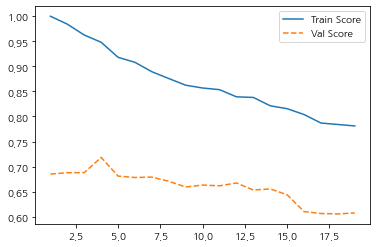

In [75]:
#모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, val_score, linestyle = "--", label = 'Val Score')
plt.legend()

* 잎사귀 노드의 최소 자료 수를 4로 지정

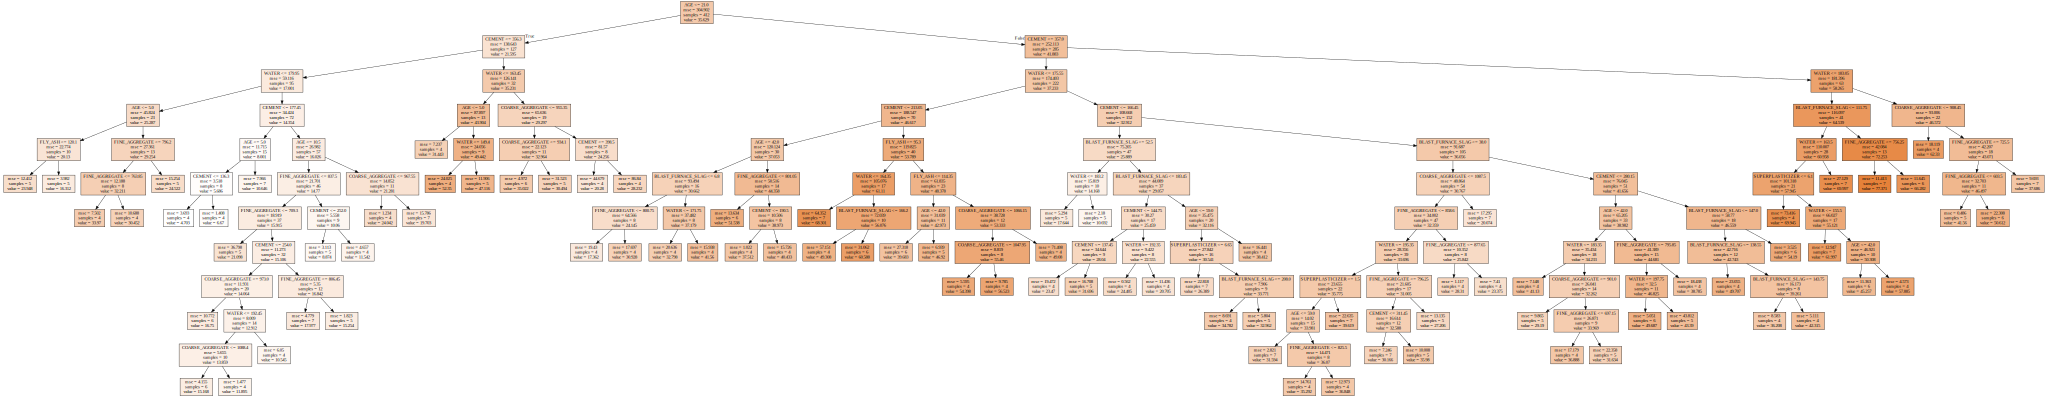

In [28]:
#변수명 저장
v_feature_name = df_train_x.columns

#노드의 최소 자료 수 = 4 모델
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 4)
tree_graph.fit(df_train_x , df_train_y)
export_graphviz(tree_graph, out_file = 'tree_leaf.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_leaf.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [77]:
#train 및 test 설명력 결과 저장
train_score = []
val_score = []

#min_samples_split : 분리노드 최소 자료 수 * 참조 : para_split : [1,2,3,...,19]

para_split = [n_split * 2 for n_split in range(2,33)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234,
                                 min_samples_leaf = 4,
                                 min_samples_split = v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    val_score.append(tree.score(df_val_x, df_val_y))

#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['ValScore'] = val_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValScore
0,4,0.948,0.718
1,6,0.948,0.718
2,8,0.948,0.718
3,10,0.939,0.712
4,12,0.926,0.700
5,14,0.910,0.703
6,16,0.902,0.693
7,18,0.884,0.680
8,20,0.873,0.660
9,22,0.865,0.665


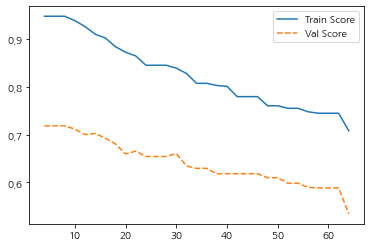

In [30]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, val_score, linestyle = "--", label = 'Val Score')
plt.legend()

* 분리 노드의 최소 자료 수를 20으로 지정 

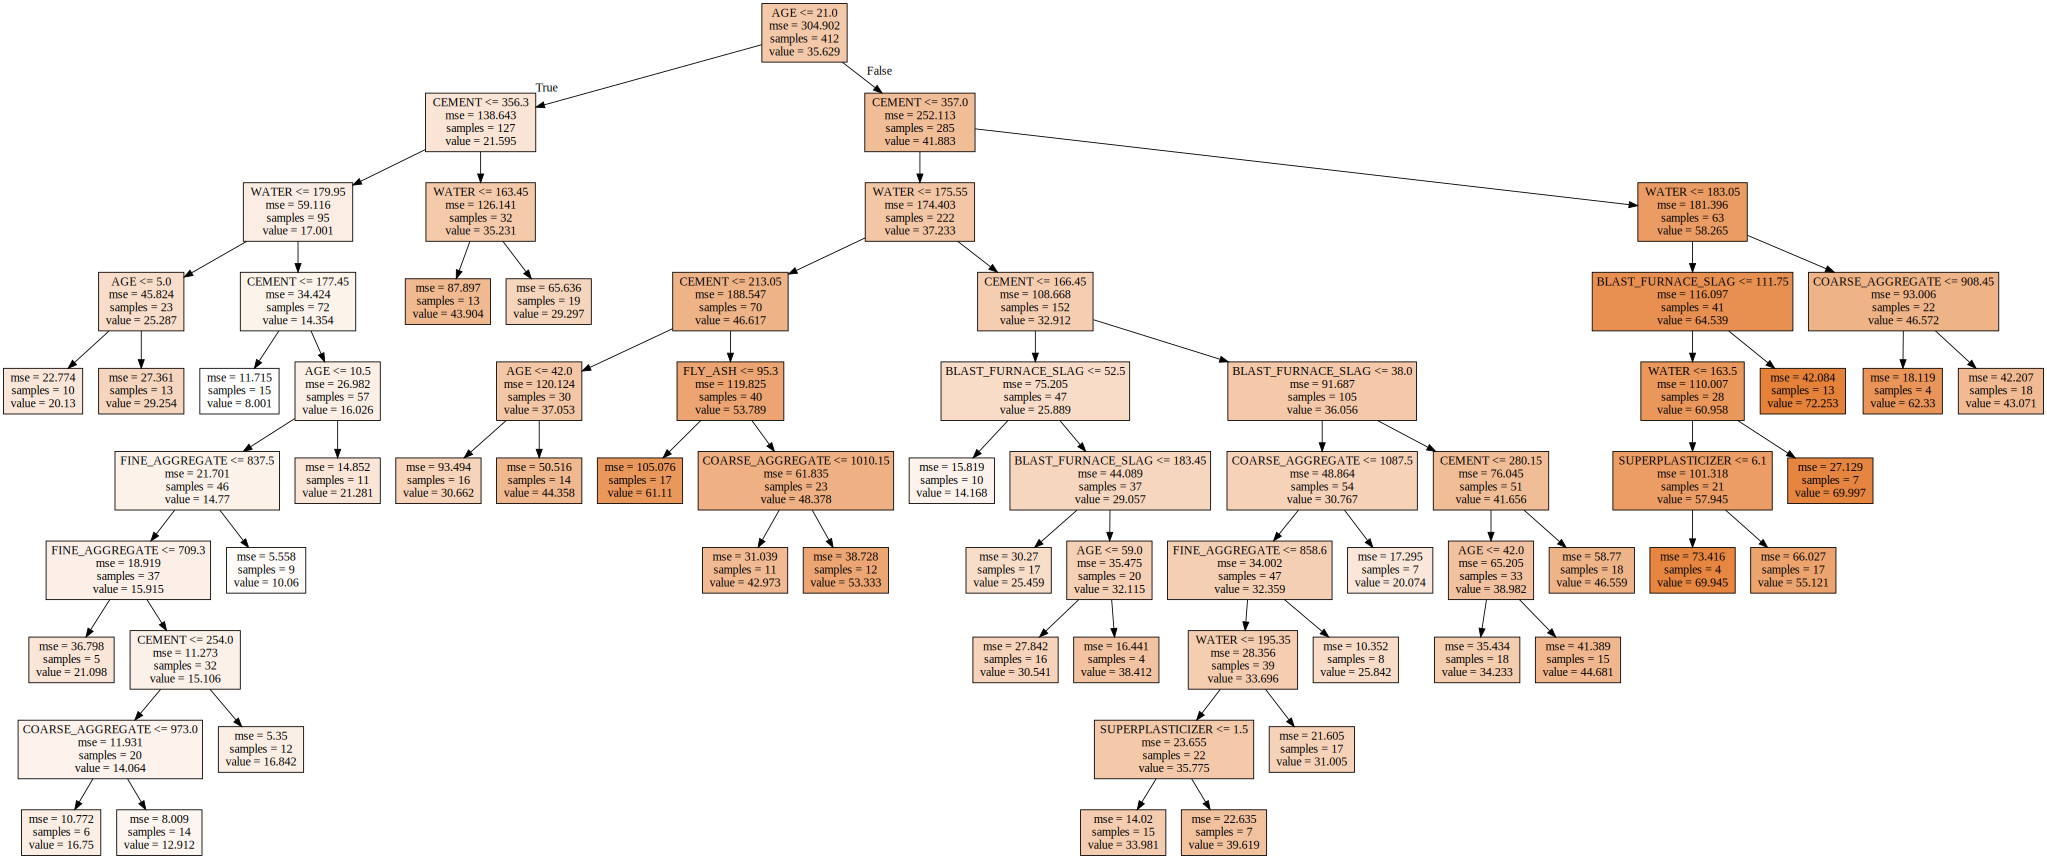

In [31]:
#변수명 저장
v_feature_name = df_train_x.columns

#분리 노드의 최소 자료 수 = 20 모델
tree_graph = DecisionTreeRegressor(min_samples_leaf = 4,
                                  min_samples_split = 20,
                                  random_state = 1234)
tree_graph.fit(df_train_x , df_train_y)
    
export_graphviz(tree_graph, out_file = 'tree_split.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_split.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Max_depth : 최대 깊이 변경에 따른 모델 성능

In [78]:
#train 및 test 설명력 결과 저장
train_score = []
val_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeRegressor(random_state = 1234,
                                 min_samples_leaf = 4,
                                 min_samples_split = 20,
                                 max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    val_score.append(tree.score(df_val_x, df_val_y))

#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['ValScore'] = val_score
df_score_depth.round(3)

,Depth,TrainScore,ValScore
0,1,0.288,0.190
1,2,0.524,0.400
2,3,0.662,0.482
3,4,0.756,0.585
4,5,0.827,0.623
5,6,0.855,0.638
6,7,0.869,0.657
7,8,0.871,0.658
8,9,0.873,0.660
9,10,0.873,0.660


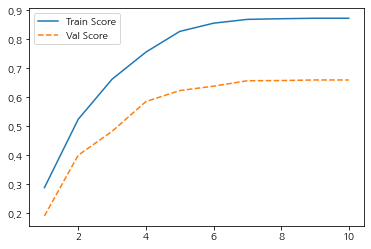

In [79]:
#모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_depth, val_score, linestyle = "--", label = 'Val Score')
plt.legend()

* 최대 깊이를 5로 지정

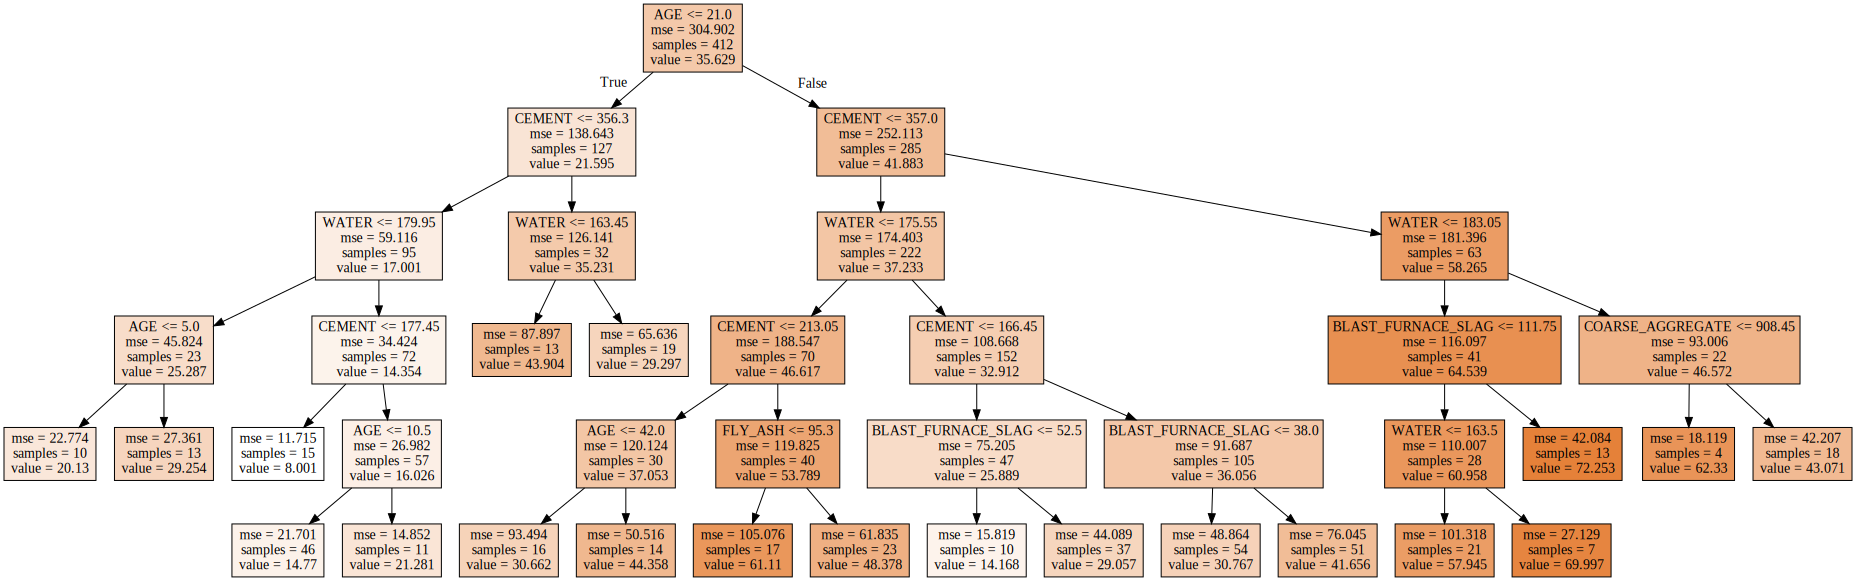

In [34]:
#변수명 저장
v_feature_name = df_train_x.columns

#최대 깊이 = 5 모델
tree_graph = DecisionTreeRegressor(min_samples_leaf = 4,
                                  min_samples_split = 20,
                                   max_depth = 5,
                                  random_state = 1234)
tree_graph.fit(df_train_x , df_train_y)
    
export_graphviz(tree_graph, out_file = 'tree_depth.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### STEP3 최종 모델 선정

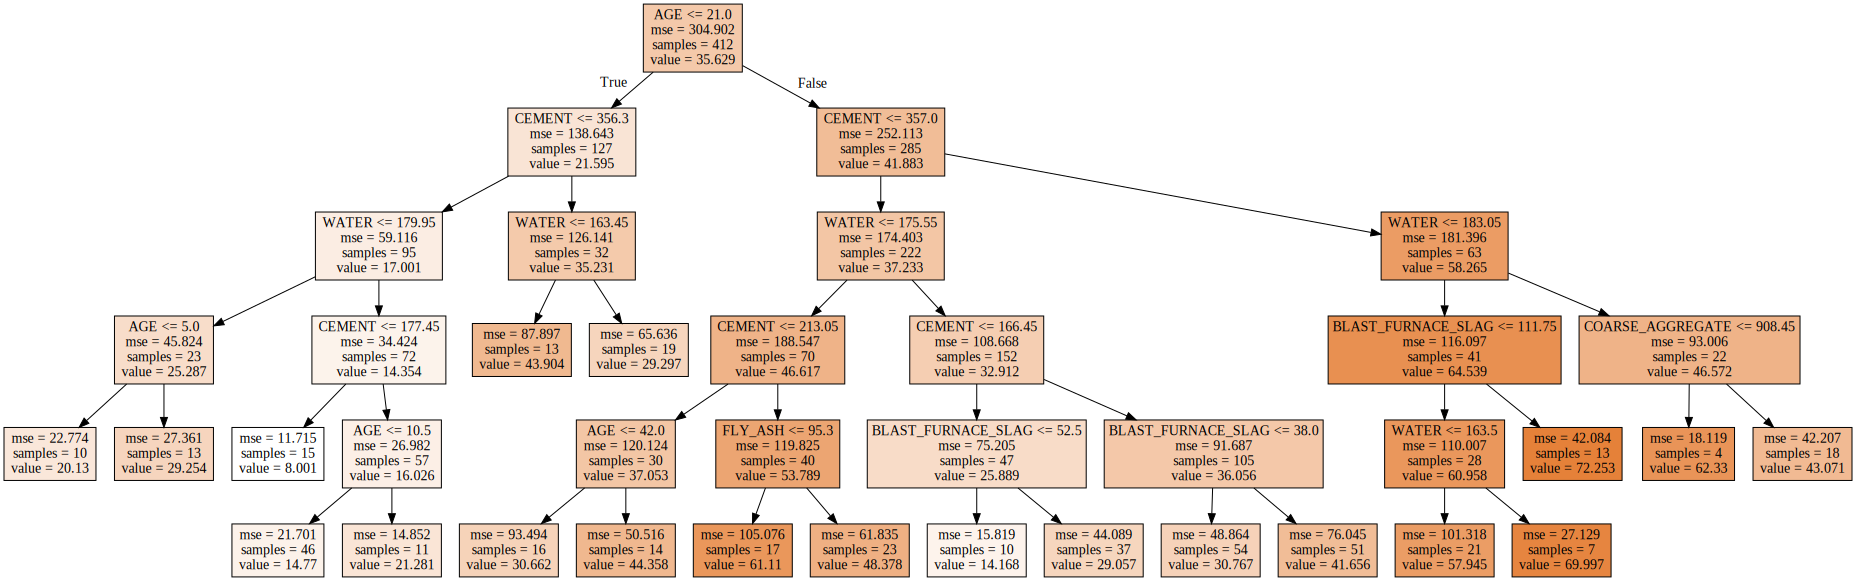

In [35]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 4, min_samples_split = 20, max_depth = 5, random_state = 1234)
tree_final.fit(df_train_x, df_train_y)

export_graphviz(tree_final, out_file = 'tree_final.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [36]:
#feature_importances_ : 설명변수의 중요도
#tree_final, feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

#df_feature_importance 의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
0,CEMENT,0.371
7,AGE,0.370
3,WATER,0.174
1,BLAST_FURNACE_SLAG,0.058
2,FLY_ASH,0.015
5,COARSE_AGGREGATE,0.012
4,SUPERPLASTICIZER,0.000
6,FINE_AGGREGATE,0.000


Text(0, 0.5, '변수')

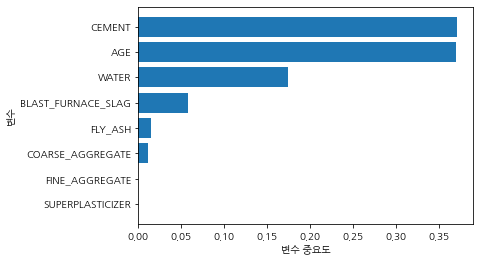

In [37]:
#설명변수 중요도 그래프, 중요도가 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

### CEMENT , AGE, WATER 순으로 영향력이 크다고 해석할 수 있음

In [38]:
#모델 생성
tree_final = DecisionTreeRegressor(min_samples_leaf = 4, min_samples_split = 20, max_depth = 5, random_state = 1234)
tree_final.fit(df_test_x, df_test_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_final.score(df_train_x, df_train_y)))

#test 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_final.score(df_test_x, df_test_y)))

Score on training set : 0.721
Score on test set : 0.810


### 최종 모델 설명력은 train 72.1%, val 81.0%

## 3. 랜덤 포레스트_예측

### STEP1 데이터 구성하기

In [39]:
df_raw = pd.read_csv('/home/piai/Downloads/Concrete.csv', engine = 'python')
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [40]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw['CONCRETE_COMPRESSIVE_STRENGTH']
df_raw_x = df_raw.drop('CONCRETE_COMPRESSIVE_STRENGTH', axis = 1 , inplace = False)

In [41]:
#train_test_split (X : 설명변수 데이터, Y : 목표변수 데이터, test_size = test 데이터 비율, random_state : random seed)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,test_size = 0.3, random_state = 1234)
df_train_x, df_val_x, df_train_y , df_val_y = train_test_split(df_train_x, df_train_y, test_size = 3/7, random_state = 1234)
print(f'train data X size :{df_train_x.shape}')
print(f'train data Y size :{df_train_y.shape}')
print(f'test data X size :{df_test_x.shape}')
print(f'test data Y size :{df_test_y.shape}')
print(f'val data X size :{df_val_x.shape}')
print(f'val data Y size :{df_val_y.shape}')

train data X size :(412, 8)
train data Y size :(412,)
test data X size :(309, 8)
test data Y size :(309,)
val data X size :(309, 8)
val data Y size :(309,)


In [42]:
#모델 생성
tree_uncustomized = RFR(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))

#val 데이터 설명력
print('Score on test set : {:.3f}'.format(tree_uncustomized.score(df_val_x, df_val_y)))

Score on training set : 0.982
Score on test set : 0.821


* 모델 설명력은 train 100%, val 82.1%

### STEP2: 모델 생성
### n_estimators: 트리 수 변경에 따른 모델 성능


In [43]:
#train 및 test 설명력 결과 저장
train_score = []
val_score = []

### n_estimators: 트리 수 변경 1~100

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]
for v_n_estimators in para_n_tree:
    rf = RFR(random_state = 1234 , 
             n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    val_score.append(rf.score(df_val_x, df_val_y))
    
#결과 저장
df_score_n = pd.DataFrame()
df_score_n['n_estimators'] = para_n_tree
df_score_n['TrainScore'] = train_score
df_score_n['TestScore'] = val_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.975,0.789
1,20,0.979,0.806
2,30,0.981,0.808
3,40,0.982,0.813
4,50,0.982,0.812
5,60,0.983,0.816
6,70,0.982,0.817
7,80,0.982,0.816
8,90,0.982,0.820
9,100,0.982,0.821


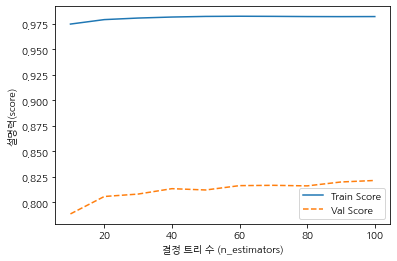

In [44]:
#모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_n_tree, val_score, linestyle = "--", label = 'Val Score')
plt.ylabel('설명력(score)')
plt.xlabel('결정 트리 수 (n_estimators)')
plt.legend()

* 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가하며 트리수가 40개를 초과해도 설명력은 거의 향상되지 않음.  
* 최대 트리 수에 따른 영향을 배제하고 다른 파라미터의 영향을 확인하고자 90 선택

### min_samples_leaf : 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [45]:
#train 및 test 설명력 결과 저장
train_score = []
val_score = []

#min_samples_leaf : 잎사귀 최소 자료 수 * 참조 : para_leaf : [1,2,3,...,19]
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(n_estimators = 90,
             random_state = 1234 , 
             min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    val_score.append(rf.score(df_val_x, df_val_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['ValScore'] = val_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,ValScore
0,1,0.982,0.820
1,2,0.969,0.808
2,3,0.952,0.801
3,4,0.936,0.789
4,5,0.921,0.777
5,6,0.908,0.767
6,7,0.895,0.753
7,8,0.882,0.747
8,9,0.870,0.739
9,10,0.861,0.731


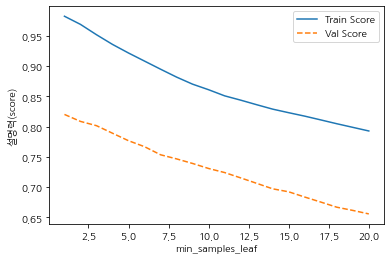

In [46]:
#모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_leaf, val_score, linestyle = "--", label = 'Val Score')
plt.ylabel('설명력(score)')
plt.xlabel('min_samples_leaf')
plt.legend()

* 잎사귀 노드의 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 val 데이터의 정확도 변화를 고려하여 4 선택

### min_samples_split : 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [47]:
#train 및 val 설명력 결과 저장
train_score = []
val_score = []

#min_samples_split : 분리노드 최소 자료 수 * 참조 : para_split : [1,2,3,...,19]

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(n_estimators = 90,
             min_samples_leaf = 4,
             random_state = 1234,
             min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    val_score.append(rf.score(df_val_x, df_val_y))

#결과 저장
df_score_split = pd.DataFrame()
df_score_split['MinSamplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['ValScore'] = val_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValScore
0,4,0.936,0.789
1,6,0.936,0.789
2,8,0.936,0.789
3,10,0.928,0.785
4,12,0.920,0.781
5,14,0.910,0.773
6,16,0.900,0.766
7,18,0.892,0.759
8,20,0.883,0.752
9,22,0.875,0.745


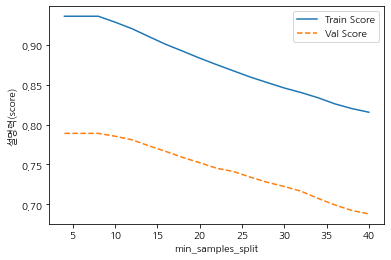

In [48]:
#모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_split, val_score, linestyle = "--", label = 'Val Score')
plt.ylabel('설명력(score)')
plt.xlabel('min_samples_split')
plt.legend()

* 분리 노드 최소 자료 수 증가에 따라 모델의 설명력은 감소하며 train/test 데이터의 성능 변화를 고려하여 8 선택

### Max_depth : 최대 깊이 변경에 따른 모델 성능

In [49]:
## train 및 val 설명력 결과 저장
train_score = []
val_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state = 1234, 
             n_estimators = 90,
             min_samples_leaf = 4,
            min_samples_split = 8,
            max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    val_score.append(rf.score(df_val_x, df_val_y))

#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['ValScore'] = val_score
df_score_depth.round(3)

,Depth,TrainScore,ValScore
0,1,0.434,0.318
1,2,0.650,0.514
2,3,0.758,0.622
3,4,0.838,0.707
4,5,0.888,0.750
5,6,0.916,0.772
6,7,0.928,0.783
7,8,0.933,0.788
8,9,0.935,0.788
9,10,0.936,0.789


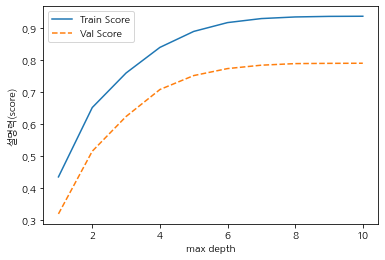

In [50]:
#모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = 'Train Score')
plt.plot(para_depth, val_score, linestyle = "--", label = 'Val Score')
plt.ylabel('설명력(score)')
plt.xlabel('max depth')
plt.legend()

* 최대 깊이 증가에 따라 모델의 설명력은 증가하며, train/test 데이터의 정확도 변화를 고려하여 10 선택

### STEP3 최종 모델 선정

In [51]:
rf_final = RFR(random_state = 1234, 
             n_estimators = 90,
             min_samples_leaf = 4,
            min_samples_split = 8,
            max_depth = 10)
rf_final.fit(df_train_x, df_train_y)

#train 데이터 설명력
print('Score on training set : {:.3f}'.format(rf_final.score(df_train_x, df_train_y)))

#test 데이터 설명력
print('Score on test set : {:.3f}'.format(rf_final.score(df_test_x, df_test_y)))

Score on training set : 0.936
Score on test set : 0.832


### 최종 모델 설명력은 train 93.6%, val 83.2%

### 최종 모델 시각화 (3개 임의 확인)

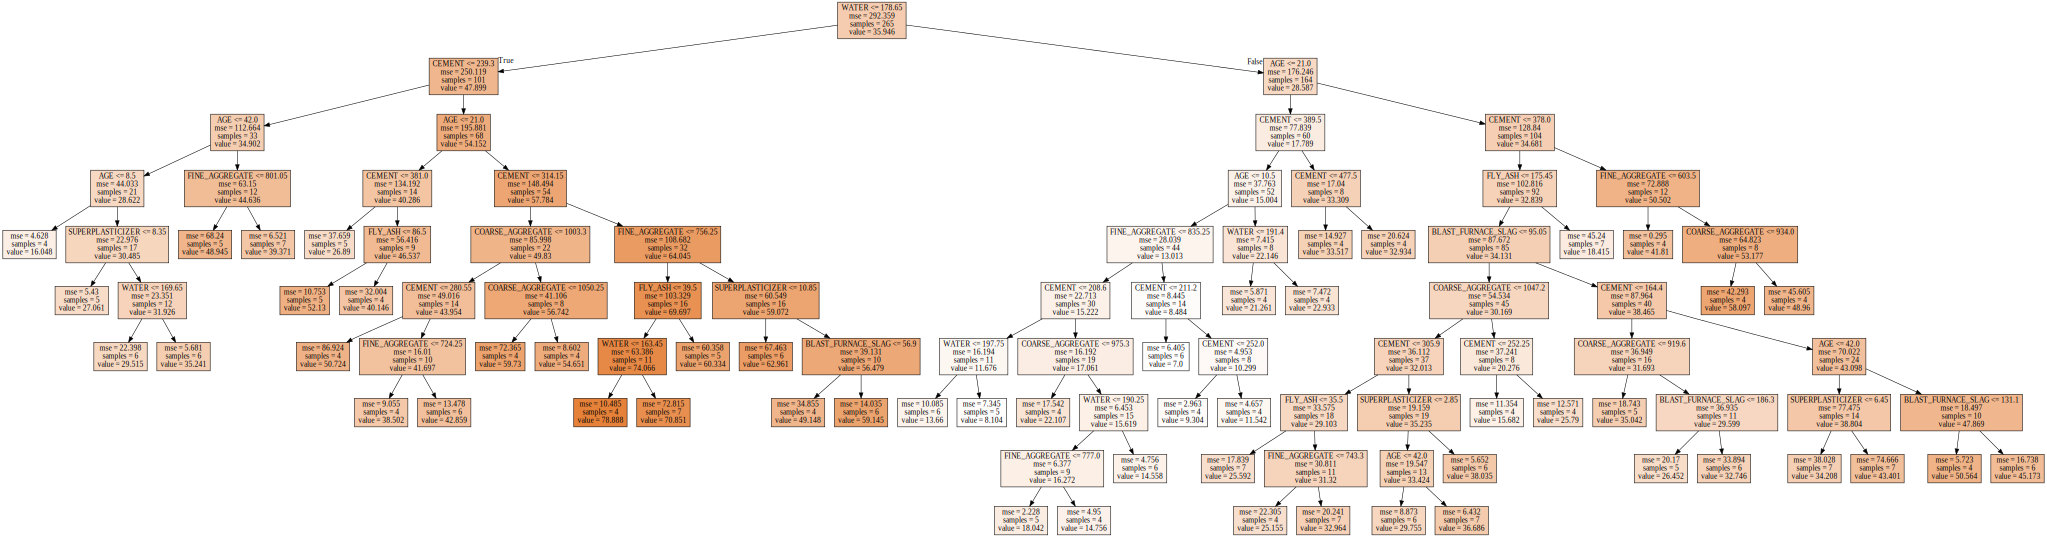

In [82]:
v_feature_name = df_train_x.columns

#0번 트리
export_graphviz(rf_final.estimators_[0], out_file = 'rf_final_0.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)

#tree_final_0.dot 그리기
with open('rf_final_0.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

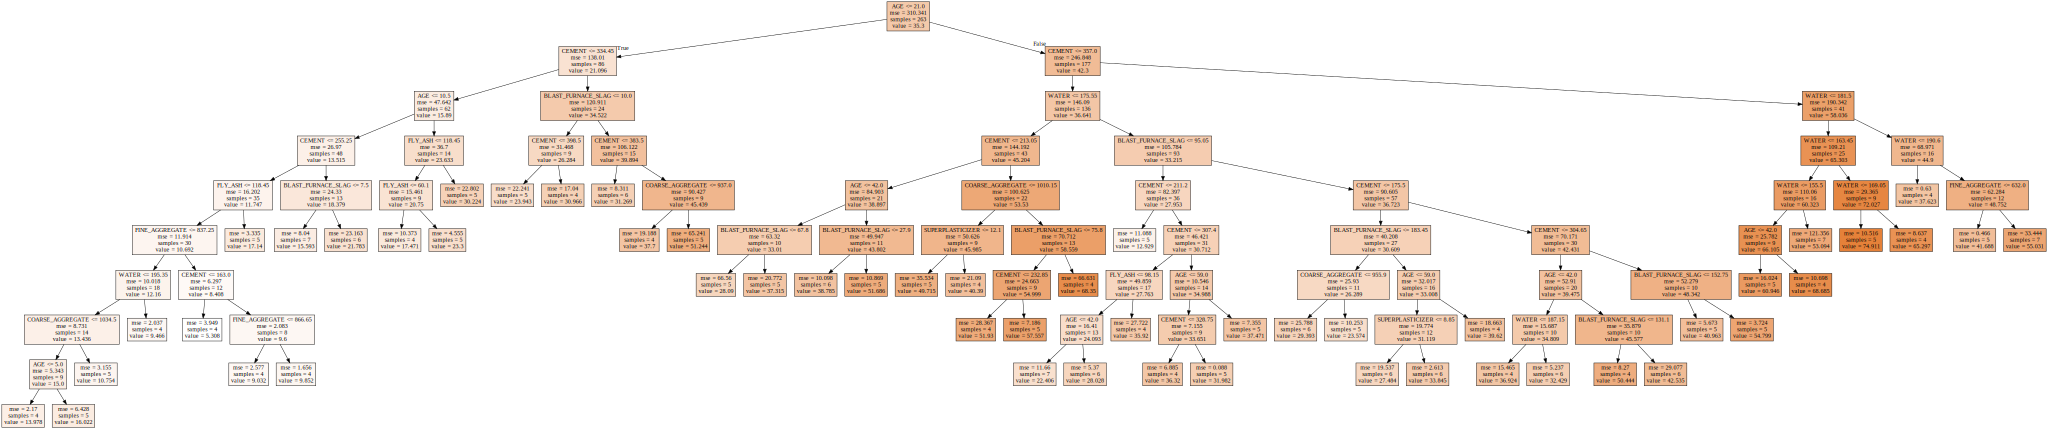

In [83]:
#1번 트리
export_graphviz(rf_final.estimators_[1], out_file = 'rf_final_1.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)

#tree_final_1.dot 그리기
with open('rf_final_1.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

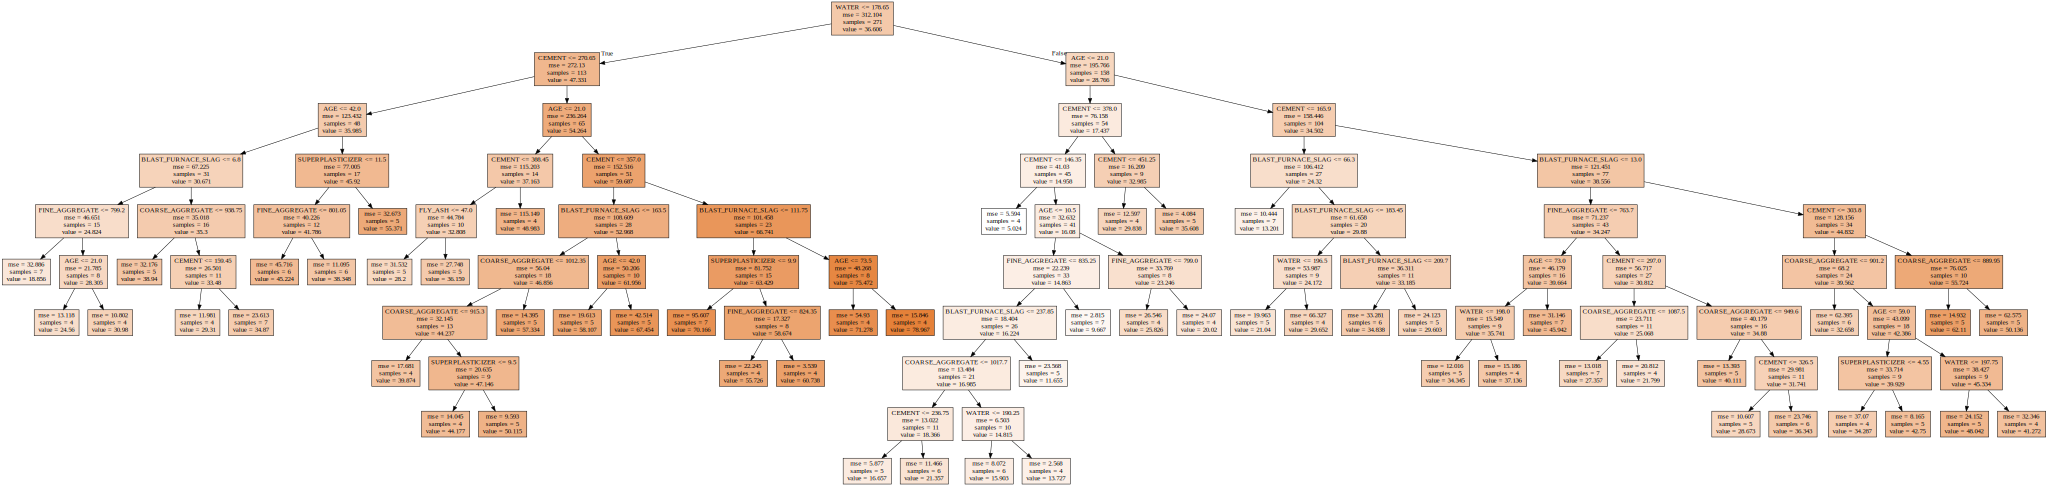

In [84]:
#10번 트리
export_graphviz(rf_final.estimators_[10], out_file = 'rf_final_10.dot', 
                feature_names = v_feature_name, impurity = True, filled = True)

#tree_final_10.dot 그리기
with open('rf_final_10.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [55]:
#feature_importances_ : 설명변수의 중요도
#tree_final, feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

#df_feature_importance 의 테이블을 중요도별로 정렬
df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.320
0,CEMENT,0.294
3,WATER,0.237
1,BLAST_FURNACE_SLAG,0.054
6,FINE_AGGREGATE,0.035
4,SUPERPLASTICIZER,0.023
5,COARSE_AGGREGATE,0.020
2,FLY_ASH,0.017


Text(0, 0.5, '변수')

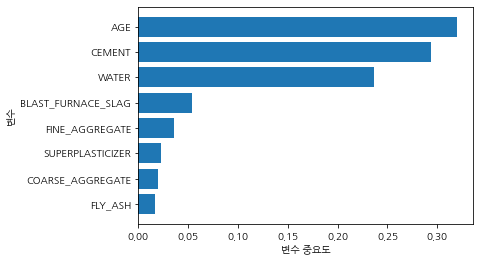

In [56]:
#설명변수 중요도 그래프, 중요도가 높은 변수를 상위에 그림
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

* AGE, CEMENT, WATER 순으로 영향이 크다고 할 수 있음

### GridSearchCV 를 이용한 최적 parameter 찾기

In [ ]:
estimator=RFR(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid={'max_depth':para_depth,'min_samples_split':para_split,\
           'min_samples_leaf':para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt=GridSearchCV(estimator,param_grid,scoring='r2',n_jobs=-1)
grid_dt.fit(df_val_x,df_val_y)
print('best estimator model:\n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score:\n{}'.format(grid_dt.best_score_.round(3)))